In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
YEARS = [2021, 2022, 2023, 2024]

In [3]:
datas = {}
ump_ngames = {}
for YEAR in YEARS:
    datas[YEAR] = pd.read_csv(f'./data/{YEAR}.csv', encoding='cp949', dtype={'umpire_id': str})
    umpgames = datas[YEAR]["umpire_id"].value_counts().to_dict()
    ump_ngames[YEAR] = umpgames

In [4]:
UMPDB    = pd.read_csv('./data/umpires.csv', encoding='cp949', dtype={'id': str}, index_col='Unnamed: 0')

In [5]:
for YEAR in YEARS:
    ump_ngames[YEAR] = {k: v for k, v in sorted(ump_ngames[YEAR].items(), key=lambda item: item[1], reverse=True)}

In [6]:
ump_lst = list(ump_ngames[YEAR].keys())
ump_lst

['5',
 '17',
 '13',
 '0',
 '24',
 '4',
 '2',
 '1',
 '23',
 '26',
 '19',
 '20',
 '6',
 '11',
 '28',
 '18',
 '7',
 '12',
 '30',
 '21',
 '22',
 '16',
 '31',
 '9',
 '33',
 '25',
 '8',
 '34',
 '14',
 '32',
 '27',
 '29',
 '15',
 '35',
 '3',
 '10']

In [7]:
from scipy.optimize import minimize
from scipy.special import expit
from scipy.linalg import inv
from numdifftools import Hessian

def logit_inv(x):
    return np.log(x / (1 - x))

def log_sum_exp(a, b):
    max_val = np.maximum(a, b)
    return max_val + np.log(np.exp(a - max_val) + np.exp(b - max_val))

def loss_function(params, x_data, y_data, r_data):
    alpha, beta, lambda_, r, x0, y0 = params
    
    log_a = np.log(np.abs(x_data - x0)) * r
    log_b = np.log(np.abs((y_data - y0) / lambda_)) * r
    
    d = np.exp(log_sum_exp(log_a, log_b) / r)
    strike_prob = expit(-beta * (d - alpha))
    
    log_likelihood = 0.0
    for i in range(len(x_data)):
        if r_data[i] == 1: 
            log_likelihood += np.log(strike_prob[i])
        else:  
            log_likelihood += np.log(1 - strike_prob[i])
    
    return -log_likelihood  
 

def infer(params, x_data, y_data):
    alpha, beta, lambda_, r, x0, y0 = params
    d = (np.abs(x_data - x0)**r + np.abs((y_data - y0) / lambda_)**r)**(1/r)
    strike_prob = expit(-beta * (d - alpha))
    return strike_prob

def fit(x_data, y_data, r_data, initial_guess=np.array([1.0, 10.0, 0.8, 3.0, 0.0, 2.5]), name="Umpire"):
    result = minimize(loss_function, initial_guess, args=(x_data, y_data, r_data), method='Nelder-Mead')
    best_params = result.x
    print(f"{name} Optimized Parameters:")
    print(f"alpha  = {best_params[0]}")
    print(f"beta   = {best_params[1]}")
    print(f"lambda = {best_params[2]}")
    print(f"r      = {best_params[3]}")
    print(f"x0     = {best_params[4]}")
    print(f"y0     = {best_params[5]}")
    return best_params

def get_credible_interval(best_params, x_data, y_data, r_data):
    try:
        hessian_matrix = Hessian(loss_function)(best_params, x_data, y_data, r_data)
        if np.any(np.isnan(hessian_matrix)) or np.any(np.isinf(hessian_matrix)):
            raise ValueError("Hessian matrix contains NaN or inf values")
        cov_matrix = inv(hessian_matrix)
        standard_errors = np.sqrt(np.diag(cov_matrix))
        z_value = 1.96  
        confidence_intervals = [
            (best_params[i] - z_value * standard_errors[i], best_params[i] + z_value * standard_errors[i])
            for i in range(len(best_params))]
        print(f"95% credible interval:")
        for i, (param, ci) in enumerate(zip(best_params, confidence_intervals)):
            print(f"Parameter {i}: {param:.4f} (95% credible interval: {ci[0]:.4f}, {ci[1]:.4f})")
        return confidence_intervals
    except Exception as e:
        print(f"Error calculating credible intervals: {e}")
        return [(np.nan, np.nan)] * len(best_params)

In [8]:
for year in YEARS:
    results_list = []
    for idx, ump in enumerate(ump_lst):
        if ump in ump_ngames[year]:
            print(f"{year} {ump:>2}: {UMPDB[UMPDB['id']==ump]['name'].item():>3} ({ump_ngames[year][ump]})")
            filtered_df = datas[year][((datas[year]['result']=='Strike')|(datas[year]['result']=='Ball'))&(datas[year]['umpire_id']==ump)]
            if filtered_df.empty:
                print(f"Skipping {ump} due to no data")
                results_list.append({
                    'year': year,
                    'ump_id': ump,
                    'name': UMPDB[UMPDB['id'] == ump]['name'].item(),
                    'pitches': 0,
                    'alpha': 0,
                    'alpha_ci_lower': 0,
                    'alpha_ci_upper': 0,
                    'beta': 0,
                    'beta_ci_lower': 0,
                    'beta_ci_upper': 0,
                    'lambda': 0,
                    'lambda_ci_lower': 0,
                    'lambda_ci_upper': 0,
                    'r': 0,
                    'r_ci_lower': 0,
                    'r_ci_upper': 0,
                    'x0': 0,
                    'x0_ci_lower': 0,
                    'x0_ci_upper': 0,
                    'y0': 0,
                    'y0_ci_lower': 0,
                    'y0_ci_upper': 0
                })
                
            else:
                x_data = filtered_df['x'].to_numpy()
                y_data = filtered_df['y'].to_numpy()
                results = filtered_df['result'].to_numpy()
                r_data = []
                for result in results:
                    if result == 'Strike':
                        r_data.append(1)
                    else:
                        r_data.append(0)
                r_data = np.array(r_data)
                print(f"Strike rate: {np.sum(r_data) / len(r_data):.4f}")
                print(f"Count: {len(r_data)}")
                best_params = fit(x_data, y_data, r_data, initial_guess=np.array([1.0, 10.0, 0.8, 25.0, 0.0, 2.5]), name=f'{ump}_{year}')
                
                print(f"{year}_{ump} Optimized Parameters:")
                print(f"alpha  = {best_params[0]}")
                print(f"beta   = {best_params[1]}")
                print(f"lambda = {best_params[2]}")
                print(f"r      = {best_params[3]}")
                print(f"x0     = {best_params[4]}")
                print(f"y0     = {best_params[5]}")
                credible_interval = get_credible_interval(best_params, x_data, y_data, r_data)
                # ci_lower, ci_upper = bootstrap_confidence_intervals(x_data, y_data, r_data, num_bootstrap=1000, alpha=0.05)
                # results_list.append({
                #         'year': year,
                #         'ump_id': ump,
                #         'name': UMPDB[UMPDB['id'] == ump]['name'].item(),
                #         'pitches': ump_ngames[year][ump],
                #         'alpha': best_params[0],
                #         'alpha_ci_lower': ci_lower[0],
                #         'alpha_ci_upper': ci_upper[0],
                #         'beta': best_params[1],
                #         'beta_ci_lower': ci_lower[1],
                #         'beta_ci_upper': ci_upper[1],
                #         'lambda': best_params[2],
                #         'lambda_ci_lower': ci_lower[2],
                #         'lambda_ci_upper': ci_upper[2],
                #         'r': best_params[3],
                #         'r_ci_lower': ci_lower[3],
                #         'r_ci_upper': ci_upper[3],
                #         'x0': best_params[4],
                #         'x0_ci_lower': ci_lower[4],
                #         'x0_ci_upper': ci_upper[4],
                #         'y0': best_params[5],
                #         'y0_ci_lower': ci_lower[5],
                #         'y0_ci_upper': ci_upper[5]
                #     })
                results_list.append({
                    'year': year,
                    'ump_id': ump,
                    'name': UMPDB[UMPDB['id'] == ump]['name'].item(),
                    'pitches': ump_ngames[year][ump],
                    'alpha': best_params[0],
                    'alpha_ci_lower': credible_interval[0][0],
                    'alpha_ci_upper': credible_interval[0][1],
                    'beta': best_params[1],
                    'beta_ci_lower': credible_interval[1][0],
                    'beta_ci_upper': credible_interval[1][1],
                    'lambda': best_params[2],
                    'lambda_ci_lower': credible_interval[2][0],
                    'lambda_ci_upper': credible_interval[2][1],
                    'r': best_params[3],
                    'r_ci_lower': credible_interval[3][0],
                    'r_ci_upper': credible_interval[3][1],
                    'x0': best_params[4],
                    'x0_ci_lower': credible_interval[4][0],
                    'x0_ci_upper': credible_interval[4][1],
                    'y0': best_params[5],
                    'y0_ci_lower': credible_interval[5][0],
                    'y0_ci_upper': credible_interval[5][1]
                })

    # Save the DataFrame to a CSV file
    print(results_list)
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(f'./result/{year}_umpire_params_and_intervals.csv', encoding='cp949', index=False)
    print()

2024  5: 송수근 (5145)
Strike rate: 0.3155
Count: 2818
5_2024 Optimized Parameters:
alpha  = 0.892247406495179
beta   = 33.77848325557184
lambda = 1.0735439312565247
r      = 16.35728145421083
x0     = 0.0015084416388911333
y0     = 2.530882507966832
2024_5 Optimized Parameters:
alpha  = 0.892247406495179
beta   = 33.77848325557184
lambda = 1.0735439312565247
r      = 16.35728145421083
x0     = 0.0015084416388911333
y0     = 2.530882507966832
95% credible interval:
Parameter 0: 0.8922 (95% credible interval: 0.8799, 0.9046)
Parameter 1: 33.7785 (95% credible interval: 28.5798, 38.9772)
Parameter 2: 1.0735 (95% credible interval: 1.0523, 1.0948)
Parameter 3: 16.3573 (95% credible interval: 2.4696, 30.2450)
Parameter 4: 0.0015 (95% credible interval: -0.0101, 0.0132)
Parameter 5: 2.5309 (95% credible interval: 2.5175, 2.5443)
2024 17: 박근영 (4896)
Strike rate: 0.3398
Count: 2743
17_2024 Optimized Parameters:
alpha  = 0.8894101400537586
beta   = 28.623229970045685
lambda = 1.0743420623765196
r

C:\Users\이기창\AppData\Local\Temp\ipykernel_20880\1251103809.py:56: RuntimeWarning: invalid value encountered in sqrt
  standard_errors = np.sqrt(np.diag(cov_matrix))


95% credible interval:
Parameter 0: 0.8882 (95% credible interval: 0.8838, 0.8926)
Parameter 1: 32.6659 (95% credible interval: 27.6266, 37.7051)
Parameter 2: 1.0805 (95% credible interval: 1.0641, 1.0969)
Parameter 3: 263483.2242 (95% credible interval: nan, nan)
Parameter 4: 0.0084 (95% credible interval: -0.0041, 0.0208)
Parameter 5: 2.5389 (95% credible interval: 2.5245, 2.5533)
2024 18: 나광남 (3892)
Strike rate: 0.3243
Count: 2097
18_2024 Optimized Parameters:
alpha  = 0.8882059200746601
beta   = 38.34376358928293
lambda = 1.0909426335273524
r      = 23.169143772420625
x0     = 0.005070317299457963
y0     = 2.5401991046026193
2024_18 Optimized Parameters:
alpha  = 0.8882059200746601
beta   = 38.34376358928293
lambda = 1.0909426335273524
r      = 23.169143772420625
x0     = 0.005070317299457963
y0     = 2.5401991046026193
95% credible interval:
Parameter 0: 0.8882 (95% credible interval: 0.8746, 0.9018)
Parameter 1: 38.3438 (95% credible interval: 31.5504, 45.1372)
Parameter 2: 1.090

C:\Users\이기창\AppData\Local\Temp\ipykernel_20880\1251103809.py:56: RuntimeWarning: invalid value encountered in sqrt
  standard_errors = np.sqrt(np.diag(cov_matrix))


95% credible interval:
Parameter 0: 0.8737 (95% credible interval: 0.8546, 0.8928)
Parameter 1: 26.5220 (95% credible interval: 19.4400, 33.6040)
Parameter 2: 1.0874 (95% credible interval: 1.0840, 1.0908)
Parameter 3: 6515.4050 (95% credible interval: nan, nan)
Parameter 4: -0.0164 (95% credible interval: -0.0427, 0.0098)
Parameter 5: 2.5077 (95% credible interval: 2.4807, 2.5346)
2024 35: 이민호42 (1030)
Strike rate: 0.2978
Count: 554
35_2024 Optimized Parameters:
alpha  = 0.8883345434526286
beta   = 36.18302211694174
lambda = 1.0712359014824955
r      = 2247.5684010680925
x0     = -0.0008410040517089592
y0     = 2.5499782772984334
2024_35 Optimized Parameters:
alpha  = 0.8883345434526286
beta   = 36.18302211694174
lambda = 1.0712359014824955
r      = 2247.5684010680925
x0     = -0.0008410040517089592
y0     = 2.5499782772984334
95% credible interval:
Parameter 0: 0.8883 (95% credible interval: 0.8649, 0.9117)
Parameter 1: 36.1830 (95% credible interval: 24.5791, 47.7870)
Parameter 2: 1

In [9]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import expit
from scipy.linalg import inv
from numdifftools import Hessian

def logit_inv(x):
    return np.log(x / (1 - x))

def loss_function(params, x_data, y_data, r_data):
    alpha, beta, lambda_, r, x0, y0 = params
    
    d = (np.abs(x_data - x0)**r + np.abs((y_data - y0) / lambda_)**r)**(1/r)
    strike_prob = expit(-beta * (d - alpha))
    
    log_likelihood = 0.0
    for i in range(len(x_data)):
        if r_data[i] == 1: 
            log_likelihood += np.log(strike_prob[i])
        else:  
            log_likelihood += np.log(1 - strike_prob[i])
    
    return -log_likelihood  

def infer(params, x_data, y_data):
    alpha, beta, lambda_, r, x0, y0 = params
    d = (np.abs(x_data - x0)**r + np.abs((y_data - y0) / lambda_)**r)**(1/r)
    strike_prob = expit(-beta * (d - alpha))
    return strike_prob


# 예제 데이터
np.random.seed(42)
x_data = np.random.rand(100)
y_data = np.random.rand(100)
r_data = np.random.randint(0, 2, 100)

# 초기 추정치
initial_guess = np.array([1.0, 10.0, 0.8, 3.0, 0.0, 2.5])

# 모델 적합
best_params = fit(x_data, y_data, r_data, initial_guess, name="Example")
print("Best Parameters:", best_params)

Example Optimized Parameters:
alpha  = 1.1567353790653914
beta   = -15.793103553471337
lambda = 13.608959509969498
r      = 225.39101263306122
x0     = -0.36857182000858424
y0     = 16.214691002408507
Best Parameters: [  1.15673538 -15.79310355  13.60895951 225.39101263  -0.36857182
  16.214691  ]


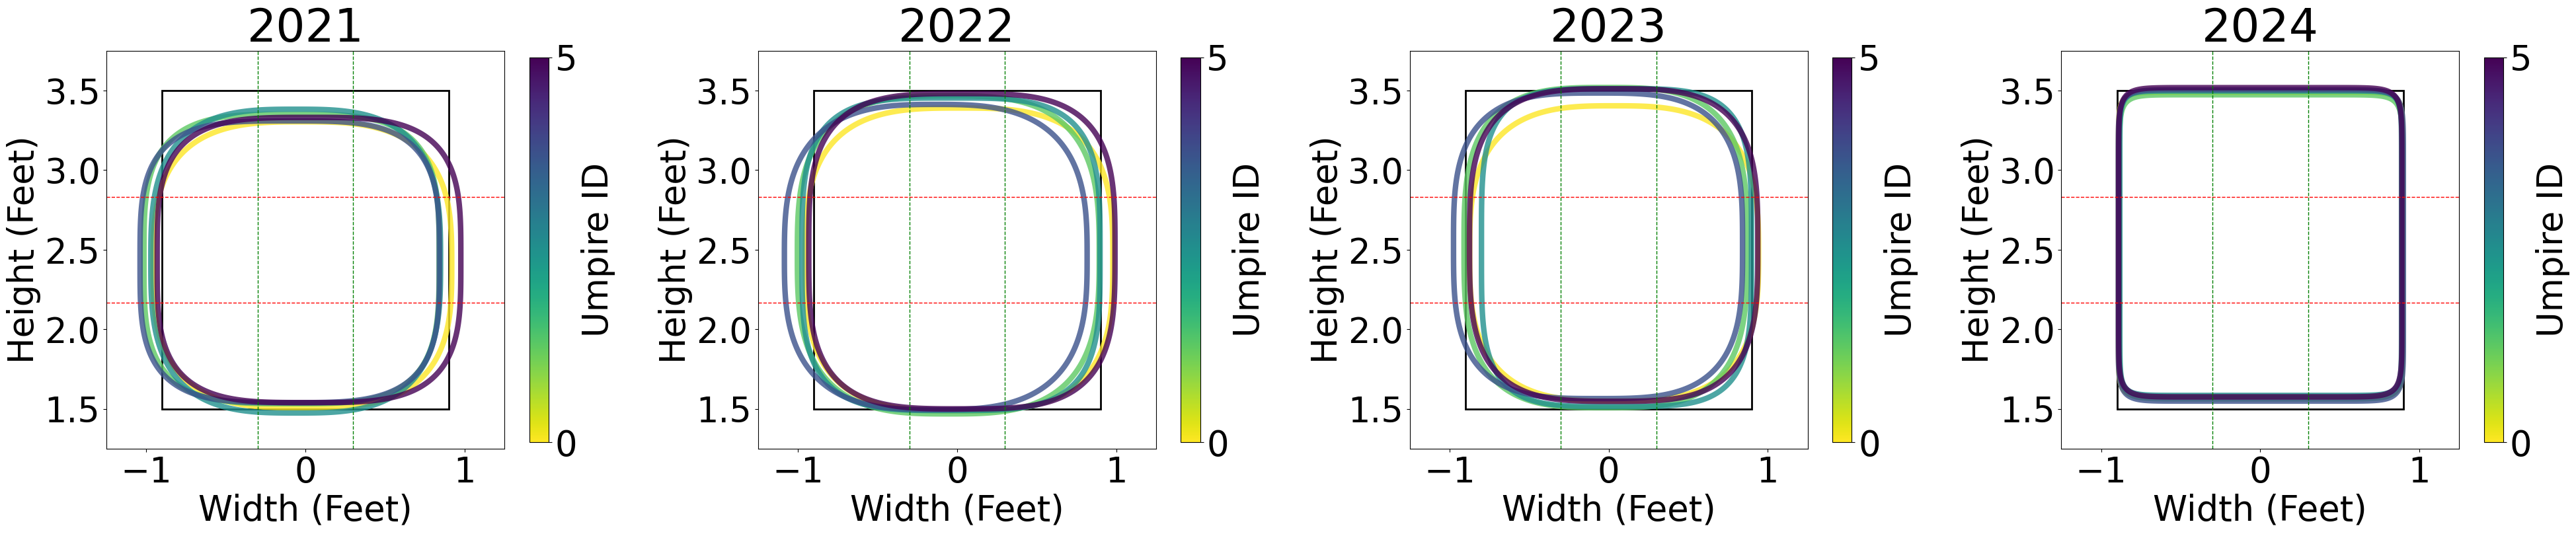

In [12]:
plt.rcParams.update({'font.size': 38})
cmap = plt.get_cmap("viridis_r")
levels = [0.5]

grid_size = 1000
fig, ax = plt.subplots(1, 4, figsize=(40, 10))
x_contour = np.linspace(-2, 2, grid_size)
y_contour = np.linspace( 0, 5, grid_size)
X, Y = np.meshgrid(x_contour, y_contour)
for idx, year in enumerate([2021, 2022, 2023, 2024]):
    ump_df    = pd.read_csv(f'./result/{year}_umpire_params_and_intervals.csv', encoding='cp949', dtype={'umpire_id': str})
    umpire_id = ump_df['ump_id'].to_numpy()[:5]
    params = {
        'alpha': ump_df['alpha'].to_numpy(),
        'beta': ump_df['beta'].to_numpy(),
        'lambda': ump_df['lambda'].to_numpy(),
        'r': ump_df['r'].to_numpy(),
        'x0': ump_df['x0'].to_numpy(),
        'y0': ump_df['y0'].to_numpy()
    }
    color = cmap(np.linspace(0,1,len(umpire_id)))
    for uidx, ump in enumerate(umpire_id):
        param = [params['alpha'][uidx], params['beta'][uidx], params['lambda'][uidx], params['r'][uidx], params['x0'][uidx], params['y0'][uidx]]
        probs = infer(param, X.reshape(-1), Y.reshape(-1))
        probs = probs.reshape((grid_size,grid_size))
        CS = ax[idx].contour(X, Y, probs, levels=levels, colors=[color[uidx]], linewidths=6.0, alpha=0.8)
        ax[idx].set_aspect('equal')
        ax[idx].set_xlim(-1.25, 1.25)
        ax[idx].set_ylim(1.25, 3.75)
    r_corner = (-0.9, 1.5)
    r_width  = 1.8
    r_height = 2.
    rectangle = plt.Rectangle(r_corner, r_width, r_height, alpha=1., linewidth=2, edgecolor='black', facecolor='none', label='Pseudo-Strike Zone')
    ax[idx].add_patch(rectangle)
    for i in range(2):
        ax[idx].axhline(y=(i+1)*(r_height/3)+r_corner[1], color='r', linestyle='--', linewidth=1.)  
        ax[idx].axvline(x=(i+1)*(r_width/3)+r_corner[0] , color='g', linestyle='--', linewidth=1.)  
    ax[idx].set_xlabel('Width (Feet)')
    ax[idx].set_ylabel('Height (Feet)')
    ax[idx].set_title(f'{year}', fontsize=50)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(umpire_id)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[idx], ticks=umpire_id, shrink=0.66)  # Only show ticks for specific years
    cbar.set_label('Umpire ID')


plt.tight_layout()
# plt.legend()
plt.savefig('./figure/umpire_strike_zone.pdf', format='pdf')
plt.show()